$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
$$

## 2D PPCA EM Demo

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [10]:
N, D, K = 300, 2, 1
C = np.array([[1.0, 0.5],
              [0.5, 1.0]])
A = np.random.multivariate_normal(np.zeros(D), C, N)
A -= np.mean(A, axis=0)

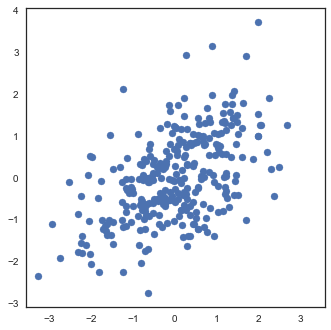

In [11]:
plt.scatter(A[:, 0], A[:, 1])
plt.axis('square')
plt.show()

### Maximum likelihood estimates

In [12]:
def eigendecompose(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    order = eigenvalues.argsort()[::-1]
    return eigenvalues[order], eigenvectors[:, order]

In [13]:
def covariance_matrix(A):
    assert len(A.shape) == 2
    N, _ = A.shape
    mu = np.mean(A, axis=0)
    return A.T @ A / N - np.outer(mu, mu)

In [14]:
empirical_C = covariance_matrix(A)

In [15]:
eigenvalues, eigenvectors = eigendecompose(empirical_C)

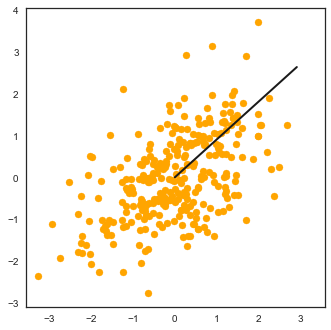

In [16]:
max_E, max_V = eigenvalues[0], eigenvectors[:, 0]

plt.scatter(A[:, 0], A[:, 1], color="orange")
plt.axis('square')
plt.plot([0, 3*np.sqrt(max_E)*max_V[0]], 
         [0, 3*np.sqrt(max_E)*max_V[1]], 
         'k-', lw=2)
plt.show()

In [17]:
W_ML = eigenvectors[:, 0] * eigenvalues[0]
sigmasq_ML = eigenvalues[1]
W_ML = np.expand_dims(W_ML, axis=1)
print(W_ML)
print(sigmasq_ML)

[[1.27235569]
 [1.14990726]]
0.5221195930242256


EM

We can also find the parameters of the model through the Expectation Maximisation algorithm.

The required expectations from the E-step are $\E[\by_i]$ and $\E[\by_i\by_i^T]$. Given we know the Gaussian posterior, these are straightforward to evaluate.

\begin{align}
\E[\by_i] &= \frac{1}{\sigma^2}\Sigma W^T\bx_i \\
\E[\by_i\by_i^T] &= \E[\by_i]\E[\by_i]^T + \Sigma
\end{align}

M-step then amounts to maximising $\theta$ given the fixed expectations over:

\begin{align}
&\E_{P(\by_{1:N} \mid \bx_{1:N})}[\log P(\bx_{1:N}, \by_{1:N})] =  \sum_i \E_{P(\by_i \mid \bx_i)}[\log P(\bx_i, \by_i)] \\
&\propto -\frac{ND}{2} \log{\sigma^2} -\frac{1}{2\sigma^2} \sum_i[ \bx_i^T\bx_i - 2\E[\by]^T W^T\bx_i + \tr(W^TW\E[\by_i\by_i^T])]-\frac{1}{2}\sum_i \E[\by_i\by_i^T]
\end{align}

Taking derivatives w.r.t. both $W$ and $\sigma^2$, setting to 0 and solving yields updates for both as:

\begin{align}
W &= (\sum_i \bx_i \E[\by_i]^T)(\sum_i \E[\by_i \by_i^T])^{-1} \\
\sigma^2 &= \frac{1}{ND}\sum_i[ \bx_i^T\bx_i - 2\E[\by]^TW^T\bx_i  + \tr(W^TW\E[\by_i\by_i^T])]
\end{align}

In [18]:
def posterior_cov(*params):
    W, sigmasq = params
    return np.linalg.inv(np.eye(K) + 1 / sigmasq * W.T @ W)

In [19]:
def neg_loglikelihood(data, *params):
    W, sigmasq = params
    
    C = W @ W.T + sigmasq * np.eye(D) 
    S = covariance_matrix(A)
    
    l = np.log(np.linalg.det(C))
    l += np.trace(np.linalg.inv(C) @ S)
    l += D * np.log(2 * np.pi)
    l *= - N / 2
    
    return l

In [20]:
def E(data, *old_params):
    old_W, old_sigmasq = old_params

    D, K = old_W.shape
    C = posterior_cov(old_W, old_sigmasq)
    
    Ey = 1 / old_sigmasq * C @ old_W.T @ data.T
    Eyyt = Ey @ Ey.T + N * C
    
    return {"y": Ey, "yyt": Eyyt}

In [21]:
def M(data, *old_params, **expectations):
    old_W, old_sigmasq = old_params
    Ey, Eyyt = expectations["y"], expectations["yyt"]

    xEy = (Ey @ data).T

    new_W = xEy @ np.linalg.inv(Eyyt)
    
    new_sigmasq = np.trace(data.T @ data)
    new_sigmasq -= 2 * np.trace(new_W.T @ xEy)
    new_sigmasq += np.trace(new_W.T @ new_W @ Eyyt)
    new_sigmasq /= N * D
    
    return new_W, new_sigmasq

In [22]:
def initial_parameters(D, K):
    init_W = np.array([[1.0],
                       [-1.0]])
    init_W /= np.linalg.norm(init_W)
    
    init_sigmasq = 1.0
    
    return init_W, init_sigmasq

In [23]:
neg_lls = []
Ws = []
sigmasqs = []

iters = 20

W, sigmasq = initial_parameters(D, K)

neg_lls.append(neg_loglikelihood(A, W, sigmasq))
Ws.append(W)
sigmasqs.append(sigmasq)
    
for _ in range(iters):
    exp_ss = E(A, W, sigmasq)
    W, sigmasq = M(A, W, sigmasq, **exp_ss)
    
    neg_lls.append(neg_loglikelihood(A, W, sigmasq))
    Ws.append(W)
    sigmasqs.append(sigmasq)

We can compare the variance obtained to the ML estimate.

In [24]:
print("Variance ML: {:.2f}  |  EM: {:.2f}".format(sigmasq_ML, sigmasq))

Variance ML: 0.52  |  EM: 0.52


Ensuring that the negative loglikelihood always increases.

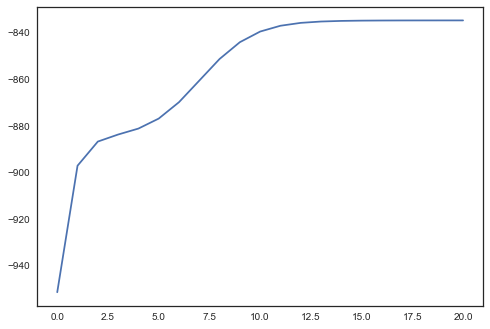

In [25]:
plt.plot(np.arange(iters+1), neg_lls)
plt.show()

We can also visualise the progression of the weight vector towards the ML estimate, plotting the first 10 iterations.

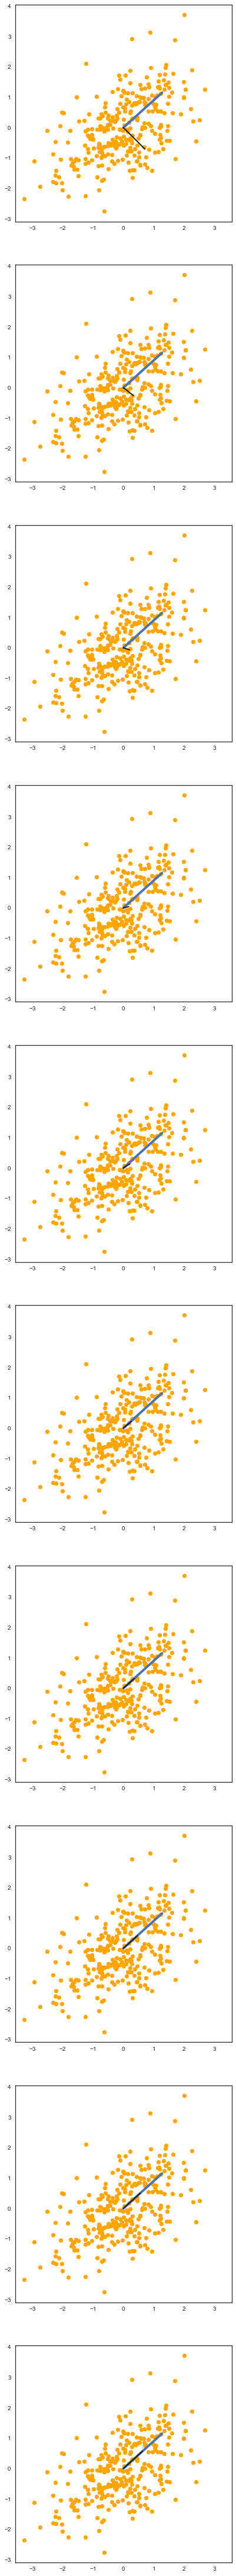

In [29]:
num_plots = 10
fig, axes = plt.subplots(nrows=num_plots, ncols=1, figsize=(8, num_plots * 8))

for i, col in enumerate(axes):
    col.scatter(A[:, 0], A[:, 1], color="orange")
    col.axis('square')
    col.plot([0, W_ML[0][0]], 
             [0, W_ML[1][0]], 
             'b-', lw=4)
    col.plot([0, Ws[i][0][0]], [0, Ws[i][1][0]], 
             'k-', lw=2)
plt.show()